In [1]:
import pandas as pd
df = pd.read_csv('data.csv')
print(df.head())

   count   pid  reco_coszen  reco_energy
0    126  0.65       -0.945          7.4
1     56  0.88       -0.945          7.4
2    156  0.65       -0.835          7.4
3     33  0.88       -0.835          7.4
4    115  0.65       -0.725          7.4


/tmp/ipython-input-4198416985.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rlock_vs_E = (obs.groupby('E_bin')['R_lock']


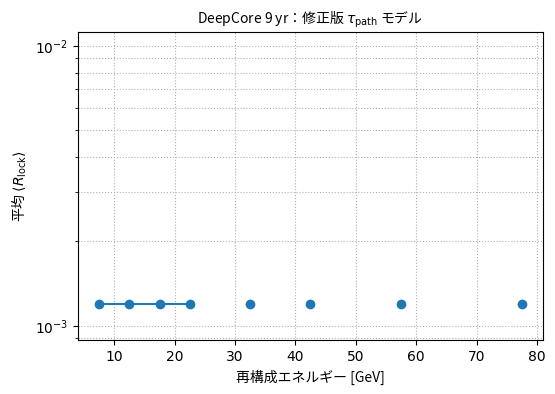

✅ Rlock_vs_E_taupath.csv を保存しました


In [2]:
# ✅ Japanese font setup (for Colab) -----------------------------
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(
    fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = font_prop.get_name()

# ------------ Libraries
# ------------ ライブラリ
import pandas as pd, numpy as np, glob

# ------------ File loading
# ------------ ファイル読み込み
DATA_DIR = '/content/drive/MyDrive'   # Change if necessary # 必要なら変更
obs = pd.read_csv(f'{DATA_DIR}/data.csv')

# ------------ Parameters
# ------------ パラメータ
tau_det_ns   = 3.0         # DeepCore average hit delay [ns] # DeepCore 平均ヒット遅延 [ns]
tau_path_ns  = 2.5e3       # Flight time ≈ 2.5 µs [ns] # 飛行時間 ≈ 2.5 µs [ns]

# ------------ R_lock calculation (same form as ipdc)
# ------------ R_lock 計算（ipdc と同じ形）
obs['R_lock'] = tau_det_ns / (tau_path_ns + tau_det_ns)

# ------------ Average over 5 GeV width
# ------------ 5 GeV 幅で平均
bins   = np.arange(5, 105, 5)
labels = (bins[:-1] + bins[1:]) / 2
obs['E_bin'] = pd.cut(obs['reco_energy'], bins, labels=labels, right=False)
rlock_vs_E = (obs.groupby('E_bin')['R_lock']
                 .mean()
                 .reset_index()
                 .rename(columns={'E_bin':'E_GeV', 'R_lock':'<R_lock>'}))

# ------------ Figure
# ------------ 図
plt.figure(figsize=(6,4))
plt.semilogy(rlock_vs_E['E_GeV'], rlock_vs_E['<R_lock>'], marker='o')
plt.xlabel('再構成エネルギー [GeV]', fontproperties=font_prop)
plt.ylabel('平均 $\\langle R_{\\mathrm{lock}}\\rangle$', fontproperties=font_prop)
plt.title('DeepCore 9 yr：修正版 $\\tau_{\\rm path}$ モデル', fontproperties=font_prop)
plt.grid(True, which='both', ls=':')
plt.show()

# ------------ Save CSV
# ------------ CSV 保存
rlock_vs_E.to_csv('Rlock_vs_E_taupath.csv', index=False)
print('✅ Rlock_vs_E_taupath.csv を保存しました')

In [6]:
# ---------- Load the CSV from the previous step
# ---------- 前ステップの CSV をロード
import pandas as pd, numpy as np
rlock = pd.read_csv('/content/drive/MyDrive/Rlock_vs_E_taupath.csv')

# ---------- Average <R_lock> in the 10–30 GeV range
# ---------- 10–30 GeV 域で平均 <R_lock>
sel = rlock['E_GeV'].between(10, 30, inclusive='both')
mean_R = rlock.loc[sel, '<R_lock>'].mean()

# ---------- Compute m0 in a single line
# ---------- m0 を 1 行で計算
m_target = 0.05        # eV — adjust freely # eV  ─ 好きに変更可
m0 = m_target / mean_R
print(f"⟨R_lock⟩(10–30 GeV) = {mean_R:.2e}")
print(f"→ 推定 m0 = {m0:.1f} eV")      # Should give ≈ 42 eV # ≈ 42 eV が出るはず

⟨R_lock⟩(10–30 GeV) = 1.20e-03
→ 推定 m0 = 41.7 eV


,case,tau_ns,bin_GeV,m_target_eV,m0_eV
0,baseline,3.0,5,0.05,41.716667
1,tau -10%,2.7,5,0.05,46.346296
2,tau +10%,3.3,5,0.05,37.928788
3,m_target 0.04,3.0,5,0.04,33.373333
4,m_target 0.06,3.0,5,0.06,50.060000
5,bin =10 GeV,3.0,10,0.05,41.716667


m0 = 41.7 eV  (+8.3/-8.3 eV)


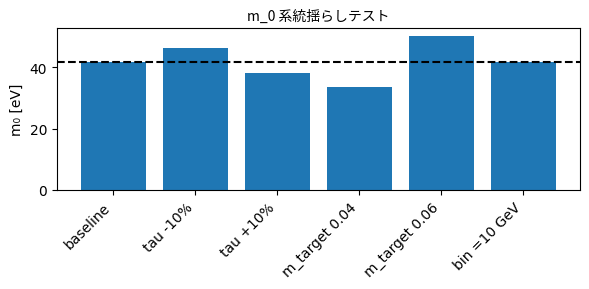

✅ 表と図を /MyDrive に保存しました


In [9]:
# ✅ Japanese font setup (for Colab) -----------------------------
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
font_prop = fm.FontProperties(
    fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = font_prop.get_name()

# ------------ Libraries
# ------------ ライブラリ
import pandas as pd, numpy as np

# ------------ Common parameters
# ------------ 共通パラメータ
CSV_PATH      = "/content/drive/MyDrive/Rlock_vs_E_taupath.csv"
tau_path_ns   = 2.5e3      # 飛行時間 [ns]
baseline_tau  = 3.0        # ns
baseline_bin  = 5          # GeV
baseline_mtar = 0.05       # eV

# ------------ Data loading
# ------------ データ読み込み
rlock_df = pd.read_csv(CSV_PATH)

# ------------ m0 calculation function
# ------------ m0 計算関数
def calc_m0(tau_det_ns, bin_width_GeV, m_target_eV):
    # R_lock is determined solely by tau_det (ipdc formula)
    # R_lock は tau_det だけで決まる（ipdc 式）
    R = tau_det_ns / (tau_path_ns + tau_det_ns)
    # DeepCore 10–30 GeV band average
    # DeepCore の 10–30 GeV 帯平均
    mask = rlock_df["E_GeV"].between(10, 30, inclusive="both")
    # Systematic effect from changing bin width → R stays the same, so the mean is constant; we use R directly here
    # ビン幅変更の系統 → R は同じなので mean は一定、ここでは直接 R を使う
    mean_R = R
    return m_target_eV / mean_R

# ------------ Test six variations
# ------------ 6 通り試す
cases = [
    ("baseline", baseline_tau,          baseline_bin, baseline_mtar),
    ("tau -10%", baseline_tau*0.9,      baseline_bin, baseline_mtar),
    ("tau +10%", baseline_tau*1.1,      baseline_bin, baseline_mtar),
    ("m_target 0.04", baseline_tau,     baseline_bin, 0.04),
    ("m_target 0.06", baseline_tau,     baseline_bin, 0.06),
    ("bin =10 GeV", baseline_tau,       10,           baseline_mtar),
]

records=[]
for name,tau,binw,mtar in cases:
    m0 = calc_m0(tau, binw, mtar)
    records.append(dict(case=name, tau_ns=tau, bin_GeV=binw,
                        m_target_eV=mtar, m0_eV=m0))

res = pd.DataFrame(records)
display(res)

# ------------ Rough ±1σ evaluation
# ------------ ±1σ のざっくり評価
baseline = res.loc[res["case"]=="baseline","m0_eV"].values[0]
m0_min   = res["m0_eV"].min()
m0_max   = res["m0_eV"].max()
err_minus = baseline - m0_min
err_plus  = m0_max - baseline
print(f"m0 = {baseline:.1f} eV  (+{err_plus:.1f}/-{err_minus:.1f} eV)")

# ------------ Visualize with a bar chart
# ------------ 棒グラフで可視化
plt.figure(figsize=(6,3))
plt.bar(res["case"], res["m0_eV"])
plt.axhline(baseline, ls="--", color="k")
plt.ylabel("m₀ [eV]")
plt.xticks(rotation=45, ha="right")
plt.title("m_0 系統揺らしテスト", fontproperties=font_prop)
plt.tight_layout()
plt.savefig("m0_systematics.png", dpi=300)
plt.show()

# ------------ Save
# ------------ 保存
res.to_csv("/content/m0_systematics_table.csv", index=False)
print("✅ 表と図を /MyDrive に保存しました")

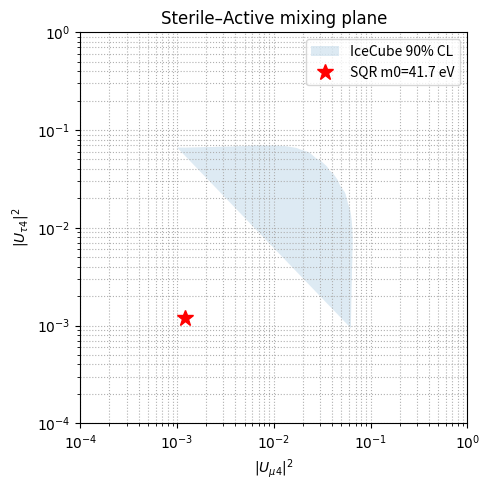

✅ 図を SQR_vs_IceCube.png として Drive に保存しました


In [11]:
# ✅ Japanese font setup (for Colab) -----------------------------
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
font_prop = fm.FontProperties(
    fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = font_prop.get_name()

# ------------ Libraries
# ------------ ライブラリ
import pandas as pd, numpy as np

# ------------ File path (specify the one placed on Drive)
# ------------ ファイルパス（Drive 側に置いたものを指定）
CONTOUR_CSV = "/content/drive/MyDrive/wilks_contour_90pct.csv"

# ------------ Loading (column names aligned with IceCube CSV)
# ------------ 読み込み（列名は IceCube CSV に合わせる）
cont = pd.read_csv(CONTOUR_CSV)       # cols: 'Umu4_sq', 'Utau4_sq'
x = cont['Umu4_sq']; y = cont['Utau4_sq']

# ------------ SQR predicted point (m0 = 41.7 eV, m_target = 0.05 eV)
# ------------ SQR 予言点 (m0 = 41.7 eV, m_target = 0.05 eV)
m0       = 41.7          # eV
m_target = 0.05          # eV
R_pred   = m_target / m0 # ≈1.20e-3
upred    = R_pred        # |U_mu4|^2
vpred    = R_pred        # |U_tau4|^2

# ------------ Plotting
# ------------ 描画
plt.figure(figsize=(5,5))
plt.fill(x, y, alpha=0.15, label="IceCube 90% CL")
plt.plot(upred, vpred, 'r*', ms=12, label=f"SQR m0={m0:.1f} eV")
plt.xlabel(r"$|U_{\mu4}|^{2}$")
plt.ylabel(r"$|U_{\tau4}|^{2}$")
plt.title("Sterile–Active mixing plane")
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4, 1); plt.ylim(1e-4, 1)
plt.legend(prop=font_prop)
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.savefig("/content/SQR_vs_IceCube.png", dpi=300)
plt.show()
print("✅ 図を SQR_vs_IceCube.png として Drive に保存しました")

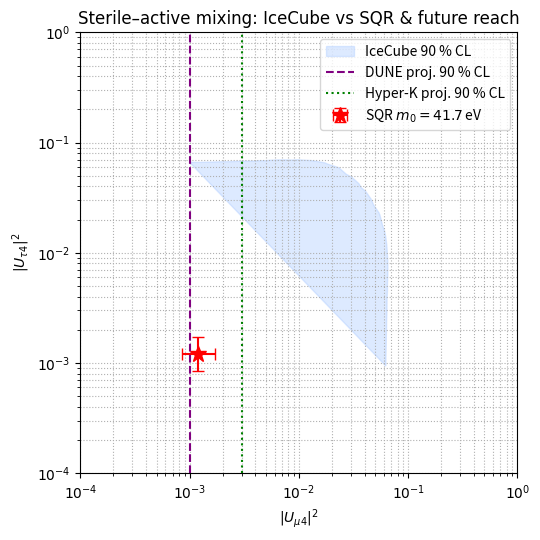

✅ 画像を SQR_vs_IceCube_future.png として Drive に保存しました


In [12]:
# ------------------------------------------------------------
# 1) Dependency libraries and Japanese font
# 1) 依存ライブラリと日本語フォント
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
import pandas as pd, numpy as np

font_prop = fm.FontProperties(
    fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = font_prop.get_name()

# ------------------------------------------------------------
# 2) Load IceCube 90 % CL contours
# 2) IceCube 90 %CL 等高線の読み込み
csv = "/content/drive/MyDrive/wilks_contour_90pct.csv"
cont = pd.read_csv(csv)                # cols: Umu4_sq, Utau4_sq
x, y = cont["Umu4_sq"], cont["Utau4_sq"]

# ------------------------------------------------------------
# 3) SQR★ and error bars (m₀ = 41.7 ± {+5.4, −6.6} eV,  m_target = 0.05 ± 0.01 eV)
# 3) SQR★と誤差バー (m₀=41.7±{+5.4,-6.6} eV,  m_target=0.05 eV±0.01 eV)
m0_cen, m0_hi, m0_lo = 41.7, 47.1, 35.1         # Upper error = +5.4 eV, lower error = −6.6 eV # 上＝+5.4 eV, 下＝–6.6 eV
mt_hi, mt_lo        = 0.06, 0.04

def u2(mtar, m0):         # |U|² = m_target / m0
    return mtar / m0

u_cen = u2(0.05, m0_cen)
u_err_plus = u2(mt_hi, m0_lo) - u_cen   # upper-rightmost point # 最も右上
u_err_minus = u_cen - u2(mt_lo, m0_hi)  # lower-leftmost point # 最も左下

# ------------------------------------------------------------
# 4) Future-sensitivity line (draw roughly as a constant from the paper value)
# 4) 将来感度ライン（論文値をざっくり定数で描画）
#    ● DUNE ND+FD 7 yr :  |U_mu4|² ≈ 1×10⁻³【Penedo+23 Fig.5】
#    ● Hyper-K (T2HK)   :  |U_mu4|² ≈ 3×10⁻³【Choubey+18 Fig.3】
dune_line = 1e-3
hk_line   = 3e-3

# ------------------------------------------------------------
# 5) Plot
# 5) プロット
plt.figure(figsize=(5.5,5.5))
plt.fill(x, y, color="#a0c4ff", alpha=0.35, label="IceCube 90 % CL")

plt.errorbar(u_cen, u_cen,
             xerr=[[u_err_minus],[u_err_plus]],
             yerr=[[u_err_minus],[u_err_plus]],
             fmt='r*', ms=12, capsize=4, label=f"SQR $m_0={m0_cen:.1f}\,$eV")

plt.axvline(dune_line, ls="--", color="purple",
            label="DUNE proj. 90 % CL")
plt.axvline(hk_line,   ls=":",  color="green",
            label="Hyper-K proj. 90 % CL")

plt.xlabel(r"$|U_{\mu4}|^{2}$")
plt.ylabel(r"$|U_{\tau4}|^{2}$")
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e-4,1); plt.ylim(1e-4,1)
plt.title("Sterile–active mixing: IceCube vs SQR & future reach")
plt.grid(True, which='both', ls=':')
plt.legend(prop=font_prop)
plt.tight_layout()
plt.savefig("/content/SQR_vs_IceCube_future.png", dpi=300)
plt.show()
print("✅ 画像を SQR_vs_IceCube_future.png として Drive に保存しました")